<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 40px;'>🚀</span>
  <span style='font-weight: bold; font-size: 32px; color: #2C4C65;'>TRM Extra Mile | Data Scientist</span>
</div>
<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-weight: normal; font-size: 19px; color: #F;'>Data Analysis</span>
</div>

<br><br>

<div style='color: #2C4C65; text-align: center; font-size: 28px; font-weight: bold'>
  <p>
    Content
  </p>
</div>
<div style='text-align: center; font-size: 20px;'>
  <span style='font-size: 20px;'>✅</span>
  <span>Developing a very simple solution for the problem - MVP</p>
</div>
<div style='text-align: center; font-size: 20px;'>
  <span style='font-size: 20px;'>✅</span>
  <span>Modelling a Machine Learning Algorithmn</p>
</div>

In [1]:
import yaml
with open('../utils/variables.yml', 'r') as file:
    variables = yaml.safe_load(file)

In [2]:
import pandas as pd
import numpy as np
import os, sys
sys.path.insert(0, os.path.abspath(".."))
from utils.plots import plotter as ptz

from utils.models import (
    create_pipeline,
    training_fased,
    plot_feature_importance,
    check_leakage,
    plot_precision_recall_and_roc,
    plot_dist,
    plot_confusion_matrix,
    plot_feature_importance,
    plot_shapley,
)

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split        
from lightgbm import LGBMClassifier, early_stopping 
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

# Reading data from data folder
df = pd.read_csv('../data/bronze_data.csv').drop(['Unnamed: 0'],axis=1)
df = df[variables['columns_keepers']]
df['BTC'] = df.apply(lambda x: x['income']/1_000_000, axis=1)

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #2C4C65;'>Defining best split criteria</span>
</div>

<br>

In [3]:
df['date_operation'] = pd.to_datetime(df['date_operation'])
df['month_year'] = df.apply(lambda x: str(x['date_operation'].month) + '_' + str(x['date_operation'].year), axis=1)

df_result = df.groupby(['month_year']).agg(
    count_operations=('target','count'),
    sum_targets=('target','sum')
).reset_index()

df_result['PropTarget'] = df_result.apply(lambda x: x['sum_targets'] / x['count_operations'], axis=1)
df_result[['month', 'year']] = df_result['month_year'].str.split('_', expand=True).astype(int)
df_sorted = df_result.sort_values(by=['year', 'month']).reset_index(drop=True)

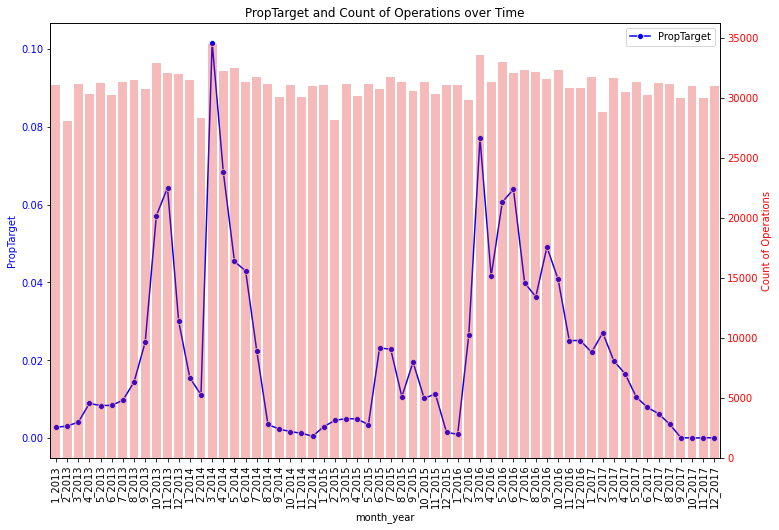

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=df_sorted, x='month_year', y='PropTarget', 
    marker='o', color='blue', label='PropTarget', ax=ax1
)
ax1.set_ylabel('PropTarget', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')


ax2 = ax1.twinx()
sns.barplot(
    data=df_sorted, x='month_year', y='count_operations', 
    alpha=0.3, color='red', ax=ax2
)
ax2.set_ylabel('Count of Operations', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.xticks(rotation=90)
plt.title('PropTarget and Count of Operations over Time')
plt.show()

In [ ]:
# black_rows=df[df["target"]==1]
# white_sample=df[df["target"]==0].sample(n=158587,random_state=42)
# sampled_df=pd.concat([black_rows,white_sample]).sample(frac=1,random_state=50)
# sampled_df.head()

# X=sampled_df.drop("target",axis=1)
# y=(sampled_df["target"]>0).astype('int')

# from sklearn.model_selection import train_test_split
# X_train, X_test,y_train, y_test = train_test_split(X,y ,
#                                    random_state=42, 
#                                    test_size=0.33, 
#                                    shuffle=True)

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #2C4C65;'>Data splits based on date</span>
</div>

<br>

In [7]:
df_train = df[
    (df['date_operation'] > '05-01-2014') &
    (df['date_operation'] <= '01-01-2017')
]

df_val = df[
    (df['date_operation'] >= '01-01-2017') &
    (df['date_operation'] <= '03-01-2017')
]

df_test = df[
    (df['date_operation'] > '03-01-2017') &
    (df['date_operation'] < '06-01-2017')
]

date_train = df_train[['date_operation']]
X_train = df_train[variables['columns_trainers']].drop(['target'],axis=1)
y_train = df_train[['target']]

date_val = df_val[['date_operation']]
X_val = df_val[variables['columns_trainers']].drop(['target'],axis=1)
y_val = df_val[['target']]

date_test = df_test[['date_operation']]
X_test = df_test[variables['columns_trainers']].drop(['target'],axis=1)
y_test = df_test[['target']]

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #2C4C65;'>Phased training before Hypertunning</span>
</div>

<br>

In [8]:
from sklearn.preprocessing import StandardScaler

pipe = create_pipeline(
    df=X_train,
    columns_ignore=[],
    columns_include_without_transformation=[],
    ordinal_order=None,
    numerical_scaler=StandardScaler(),
)

pipe_prep_features = pipe[0] ; pipe[0]

Ignorando essas colunas tanto para OneHot quanto para Numerical: []
['length', 'weight', 'count', 'looped', 'neighbors', 'income', 'BTC', 'whichDayWeek']
[]
DataFrames criados sendo numericas:8, one_hot:0, ordinal:0
Pipelines criados, criando of FeatureUnion


FeatureUnion(transformer_list=[('pipe_num',
                                Pipeline(steps=[('selector_numerical',
                                                 ColumnTransformer(transformers=[('filter_num_cols',
                                                                                  'passthrough',
                                                                                  array(['length', 'weight', 'count', 'looped', 'neighbors', 'income',
       'BTC', 'whichDayWeek'], dtype=object))])),
                                                ('num_imputer',
                                                 SimpleImputer(strategy='median')),
                                                ('NumScaler',
                                                 StandardScaler())])),
                               ('pipe_sem_mexer',
                                Pipeline(steps=[('selector_one_hot',
                                                 ColumnTransformer(transformers=[('filter_ignore_cols',
                                                                                  'passthrough',
                                                                                  array([], dtype=object))]))]))])

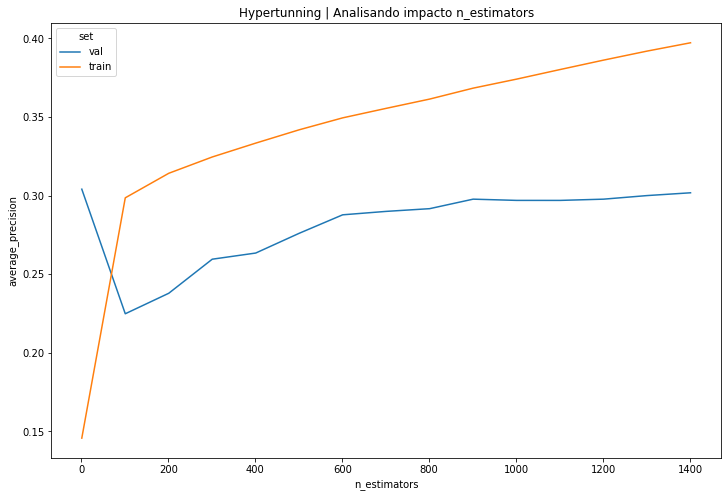

In [ ]:
df_plot = training_fased(
    hyper_parameter='n_estimators',
    dict_parameters={
        'class_weight': 'balanced'
    },
    limit_down_range=1,
    limit_up_range=1500,
    step=100,
    model=Pipeline([
        ('transformer_prep', pipe_prep_features),
        ('estimator', LGBMClassifier(random_state=42))
    ]),
    metric=average_precision_score,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)

from utils.plots import plot_result_metric

plot_result_metric(
    df_plot=df_plot,
    xlabel='n_estimators',
    ylabel='average_precision',
    title='Hypertunning | Analisando impacto n_estimators',
    huer='set'
)

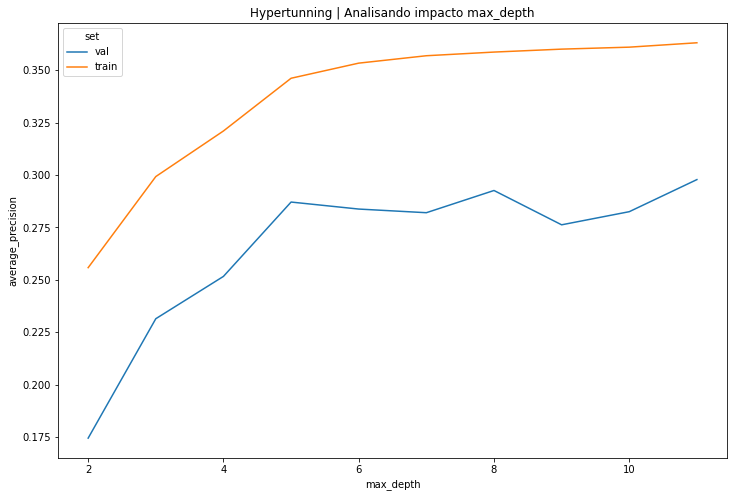

In [48]:
df_plot = training_fased(
    hyper_parameter='max_depth',
    dict_parameters={
        'n_estimators': 800,
        'class_weight': 'balanced'
    },
    limit_down_range=2,
    limit_up_range=12,
    step=1,
    model=Pipeline([
        ('transformer_prep', pipe_prep_features),
        ('estimator', LGBMClassifier(random_state=42, verbose=-1))
    ]),
    metric=average_precision_score,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)

plot_result_metric(
    df_plot=df_plot,
    xlabel='max_depth',
    ylabel='average_precision',
    title='Hypertunning | Analisando impacto max_depth',
    huer='set'
)

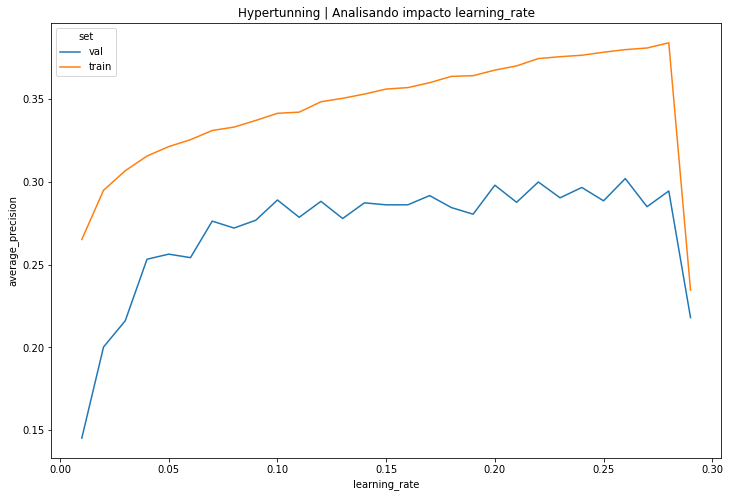

In [49]:
df_plot = training_fased(
    hyper_parameter='learning_rate',
    dict_parameters={
        'n_estimators': 700,
        'max_depth': 5,
        'min_child_samples': 22,
        'class_weight': 'balanced'
    },
    limit_down_range=0.01,
    limit_up_range=0.3,
    step=0.01,
    model=Pipeline([
        ('transformer_prep', pipe_prep_features),
        ('estimator', LGBMClassifier(random_state=42))
    ]),
    metric=average_precision_score,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)

plot_result_metric(
    df_plot=df_plot,
    xlabel='learning_rate',
    ylabel='average_precision',
    title='Hypertunning | Analisando impacto learning_rate',
    huer='set'
)

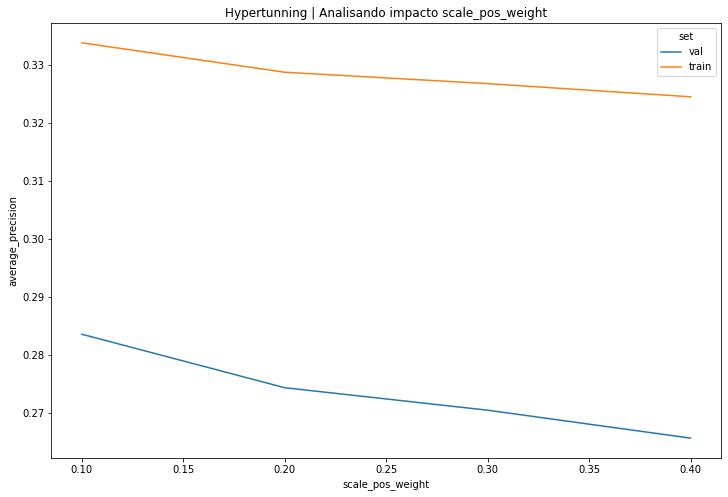

In [51]:
df_plot = training_fased(
    hyper_parameter='scale_pos_weight',
    dict_parameters={
        'n_estimators': 800,
        'max_depth': 8,
        'min_child_samples': 22,
        'learning_rate': 0.1,
        'boosting_type': 'dart',
        'class_weight': 'balanced'
    },
    limit_down_range=0.1,
    limit_up_range=0.4,
    step=0.1,
    model=Pipeline([
        ('transformer_prep', pipe_prep_features),
        ('estimator', LGBMClassifier(random_state=42))
    ]),
    metric=average_precision_score,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)

plot_result_metric(
    df_plot=df_plot,
    xlabel='scale_pos_weight',
    ylabel='average_precision',
    title='Hypertunning | Analisando impacto scale_pos_weight',
    huer='set'
)

### RandomSearchCV

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from scipy.stats import uniform, randint

pipe_tuning = Pipeline([
    ('transformer_prep', pipe_prep_features),
    ('estimator',LGBMClassifier(random_state=42))
])

cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 42)
metric = 'average_precision'

params = {
    'estimator__n_estimators': [800],
    'estimator__max_depth':[8],
    'estimator__min_child_samples':[22],
    'estimator__learning_rate':[0.1],
    'estimator__class_weight':['balanced'],
    'estimator__scale_pos_weight': [0.1],
    'estimator__num_leaves':[40],
    'estimator__boosting_type': ['dart']
}

fit_params = {
        'estimator__eval_set':[(X_val, y_val)],
        'estimator__callbacks':[(early_stopping(stopping_rounds=10, verbose=False))],
        'estimator__eval_metric': metric
}

random_search = RandomizedSearchCV(
    estimator= pipe_tuning,
    param_distributions=params,
    n_iter=5,
    scoring=metric,
    refit=True,
    cv=3,
    random_state=42,
    error_score='raise'
)

random_search.fit(
    X_train, 
    y_train,
    **fit_params
)

print('####################')
print(random_search.best_score_)
print(random_search.best_params_)

y_pred = random_search.predict_proba(X_val)[:, 1]
y_pred_train = random_search.predict_proba(X_train)[:, 1]

####################
0.3009617655793324
{'estimator__scale_pos_weight': 0.1, 'estimator__num_leaves': 40, 'estimator__n_estimators': 800, 'estimator__min_child_samples': 22, 'estimator__max_depth': 8, 'estimator__learning_rate': 0.1, 'estimator__class_weight': 'balanced', 'estimator__boosting_type': 'dart'}


<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #2C4C65;'>Model Performance: Holdout validation set</span>
</div>

<br>

In [13]:
import pickle
with open('model.pkl', 'rb') as file:
    random_search = pickle.load(file)

In [14]:
y_pred_label = random_search.predict(X_train)
print(classification_report(y_train, y_pred_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    975000
           1       0.40      0.37      0.38     23102

    accuracy                           0.97    998102
   macro avg       0.69      0.68      0.69    998102
weighted avg       0.97      0.97      0.97    998102



In [15]:
y_pred_label = random_search.predict(X_val)
print(classification_report(y_val, y_pred_label))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     60000
           1       0.32      0.35      0.34      1490

    accuracy                           0.97     61490
   macro avg       0.65      0.67      0.66     61490
weighted avg       0.97      0.97      0.97     61490



Você possui 7 features com importância acima de 1.5%
Isso representa 88.0%
Você possui no total 8 features


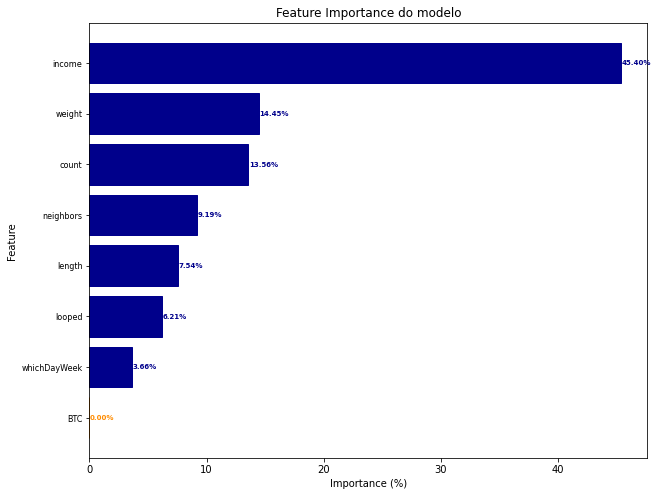

<Figure size 432x288 with 0 Axes>

In [16]:
features = plot_feature_importance(
    model_hyperopt=random_search,
    model_step='estimator',
    preprocessing_step='transformer_prep',
    RFE=False,
    HyperTuner=True
)

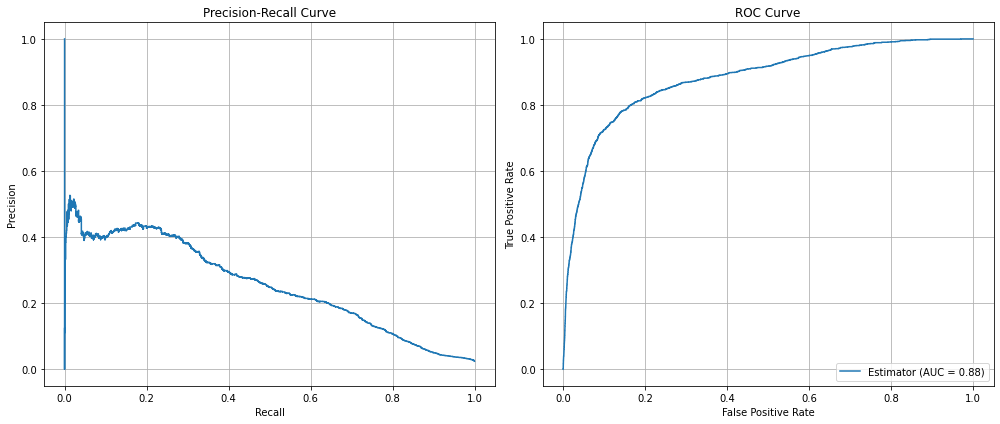

In [17]:
plot_precision_recall_and_roc(
    y_true=y_val, 
    y_pred=y_pred, 
    estimator_name="Estimator"
)

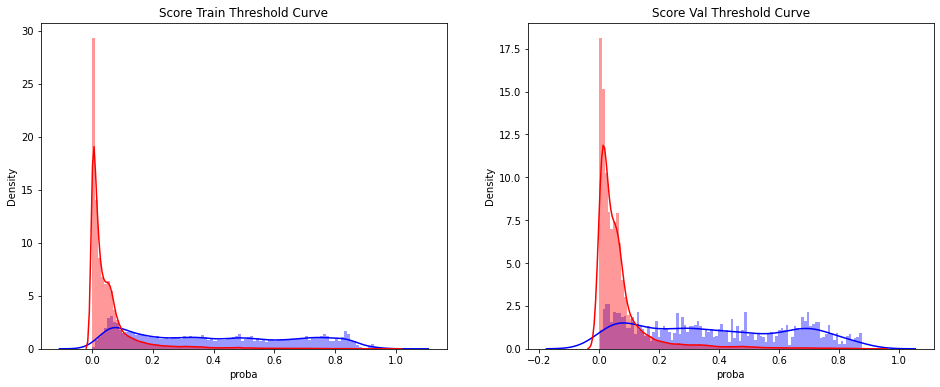

In [18]:
y_pred = random_search.predict_proba(X_val)[:, 1]
y_pred_train = random_search.predict_proba(X_train)[:, 1]

plot_dist(
    y_train=y_train,
    pred_proba_train=y_pred_train,
    y_val=y_val,
    pred_proba_val=y_pred,
    split='Val'
)

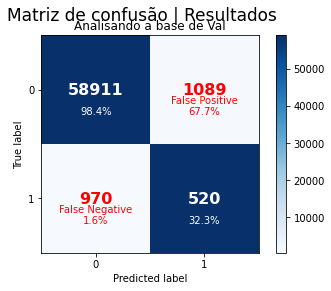

In [19]:
y_pred_label_val = random_search.predict(X_val)
plot_confusion_matrix(
    y_true=y_val, 
    y_pred=y_pred_label_val, 
    split='Val', 
    position_title=0.475
)

<br><br>

<div style='text-align: center; font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;'>
  <span style='font-size: 30px;'>📊</span>
  <span style='font-weight: bold; font-size: 32px; color: #2C4C65;'>Model Development: OOS results</span>
</div>

<br>

In [20]:
y_pred_label = random_search.predict(X_test)
print(classification_report(y_test, y_pred_label))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     91000
           1       0.19      0.31      0.24      1447

    accuracy                           0.97     92447
   macro avg       0.59      0.64      0.61     92447
weighted avg       0.98      0.97      0.97     92447



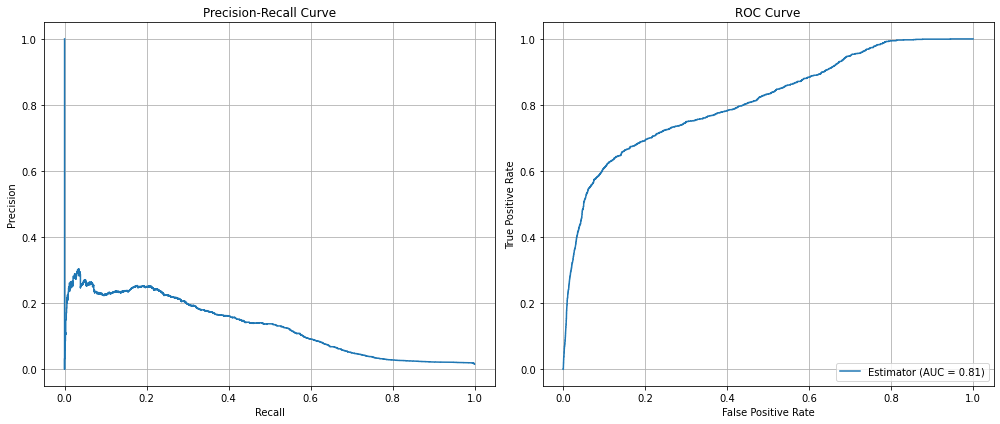

In [21]:
y_pred = random_search.predict_proba(X_test)[:,1]
plot_precision_recall_and_roc(
    y_true=y_test, 
    y_pred=y_pred, 
    estimator_name="Estimator"
)

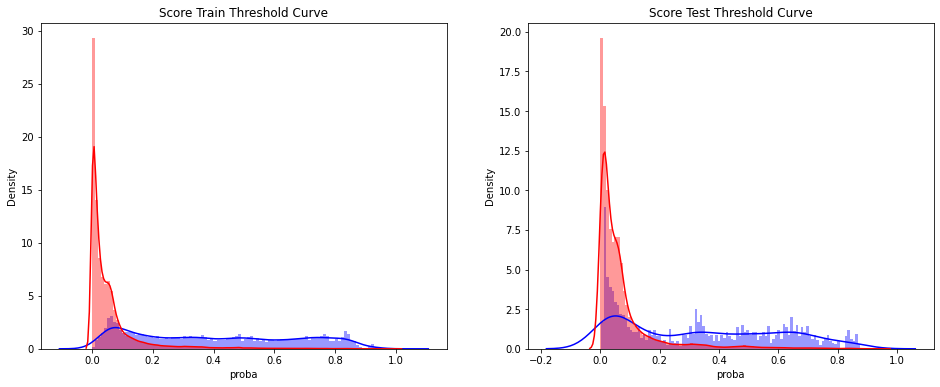

In [22]:
y_pred = random_search.predict_proba(X_test)[:, 1]
y_pred_train = random_search.predict_proba(X_train)[:, 1]

plot_dist(
    y_train=y_train,
    pred_proba_train=y_pred_train,
    y_val=y_test,
    pred_proba_val=y_pred,
    split='Test'
)

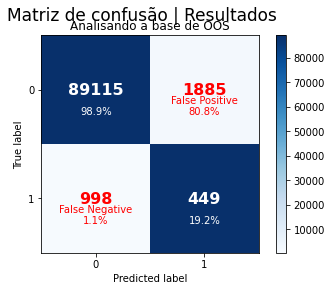

In [23]:
y_pred_label_test = random_search.predict(X_test)
plot_confusion_matrix(
    y_true=y_test, 
    y_pred=y_pred_label_test, 
    split='OOS', 
    position_title=0.475
)